<a href="https://colab.research.google.com/github/kareemullah123456789/bigdatafoundation-july8-new/blob/main/optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Optimizing PySpark code generally involves minimizing network I/O (shuffling), managing memory efficiently, and leveraging Spark’s distributed architecture correctly.


### 1\. Optimize Transformations & Actions

The most efficient code uses Spark's native internal optimizations (Catalyst Optimizer) rather than opaque Python code.

  * **Avoid Standard Python UDFs:** Standard Python User Defined Functions (UDFs) impose a high overhead because data must be serialized between the JVM and Python processes (pickling).

      * **Solution:** Use **Pandas UDFs (Vectorized UDFs)** which use Apache Arrow to transfer data, or stick to native Spark SQL functions (`pyspark.sql.functions`) whenever possible.
      * **Enable Arrow:** `spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")`

  * **Filter Early (Predicate Pushdown):** Apply `.filter()` or `.where()` **before** you perform joins or complex transformations. This reduces the dataset size immediately, minimizing the data passed through the pipeline.

  * **`reduceByKey` vs `groupByKey`:**

      * **Avoid:** `groupByKey` triggers a massive shuffle, moving all data to specific nodes before processing.
      * **Prefer:** `reduceByKey` performs a map-side combine (pre-aggregation) on the local node *before* shuffling the data, significantly reducing network traffic.

### 2\. Optimize Joins

Joins are often the most expensive operations in Spark jobs.

  * **Broadcast Joins:** If joining a large table with a small table, broadcast the small table. This sends a copy of the small table to every worker node, eliminating the need to shuffle the large table.
    ```python
    from pyspark.sql.functions import broadcast

    # Forces a broadcast join
    df_joined = large_df.join(broadcast(small_df), "id")
    ```
      * *Note:* Spark does this automatically for tables smaller than 10MB (configurable via `spark.sql.autoBroadcastJoinThreshold`), but explicit broadcasting is safer for edge cases.

[Image of Spark Broadcast Join architecture]

  * **Handle Data Skew:** If one key has significantly more data than others, tasks will hang waiting for that one "heavy" partition to finish.
      * **Solution:** Salt the skewed keys (add a random number to the key) to distribute the data, perform the operation, and then unsalt.
      * **AQE:** Enable Adaptive Query Execution (`spark.sql.adaptive.enabled=true`), which can dynamically handle skew joins in newer Spark versions (3.0+).

### 3\. Managing Partitions & Shuffling

Data movement across the network (shuffling) is the biggest bottleneck.

  * **`coalesce` vs `repartition`:**

      * Use **`coalesce(n)`** to **decrease** the number of partitions. It avoids a full shuffle by merging existing partitions.
      * Use **`repartition(n)`** to **increase** partitions or when you need to redistribute data evenly (full shuffle).

  * **Tune Shuffle Partitions:** The default `spark.sql.shuffle.partitions` is 200.

      * **For small data:** 200 is too high (too much overhead). Reduce it (e.g., 10-50).
      * **For massive data:** 200 is too low (partitions become too large, causing OOM). Increase it so each partition is roughly 128MB - 200MB.

### 4\. Caching and Persistence

Do not cache indiscriminately. Caching takes up RAM that could otherwise be used for execution.

  * **When to Cache:** Only cache a DataFrame if it is reused in **multiple subsequent actions** (e.g., used in two different joins or a count followed by a save).
  * **Storage Level:**
      * `df.cache()` stores in memory.
      * `df.persist(StorageLevel.MEMORY_AND_DISK)` spills to disk if memory fills up, preventing crashes.
  * **Unpersist:** Always call `df.unpersist()` when you are done with the DataFrame to free up memory.

### 5\. File Format & I/O

  * **Use Parquet:** It is a columnar storage format that supports **partition pruning** (skipping files that don't match your query) and only reads the columns you request.
  * **Avoid `collect()`:** Never use `.collect()` on large datasets. It brings all data to the driver node, which will likely crash the driver with an OutOfMemory error. Use `.take(n)` or `.head()` for debugging.

-----

### Summary Checklist for Optimization

| Feature | Optimization Tip |
| :--- | :--- |
| **Serialization** | Use `KryoSerializer` (faster/compact) over Java serialization. |
| **Functions** | Use `pyspark.sql.functions` or Pandas UDFs; avoid Python loops. |
| **Joins** | Broadcast small tables; check for skewed keys. |
| **Partitions** | `coalesce` to reduce partitions; ensure partition size is \~128MB. |
| **Config** | Enable Adaptive Query Execution (`spark.sql.adaptive.enabled = true`). |



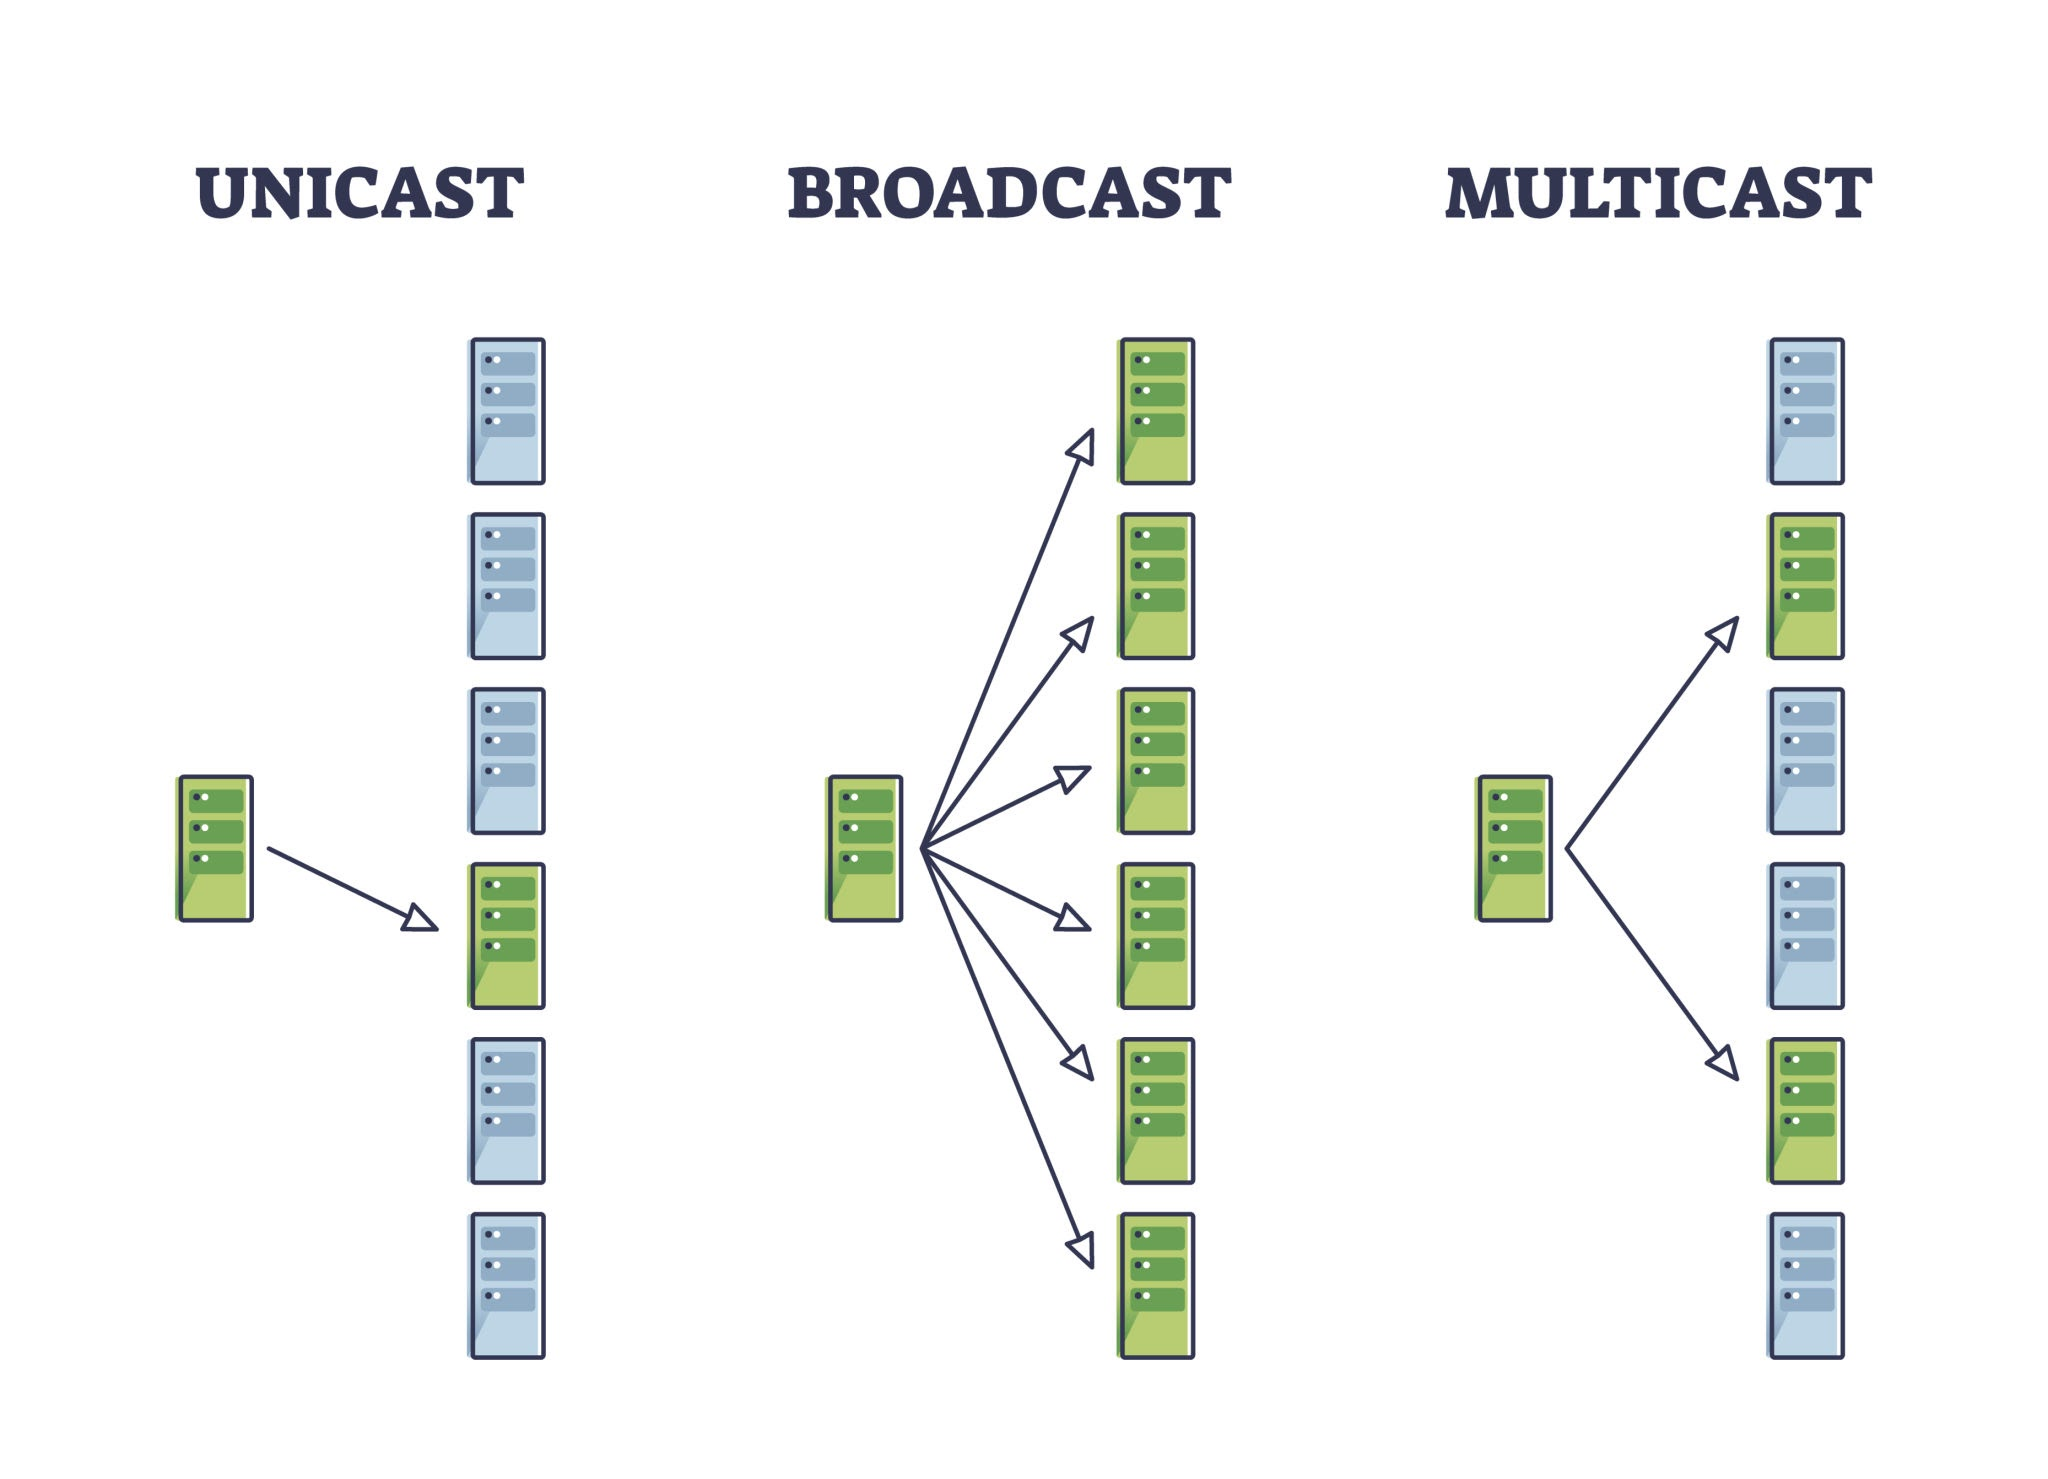

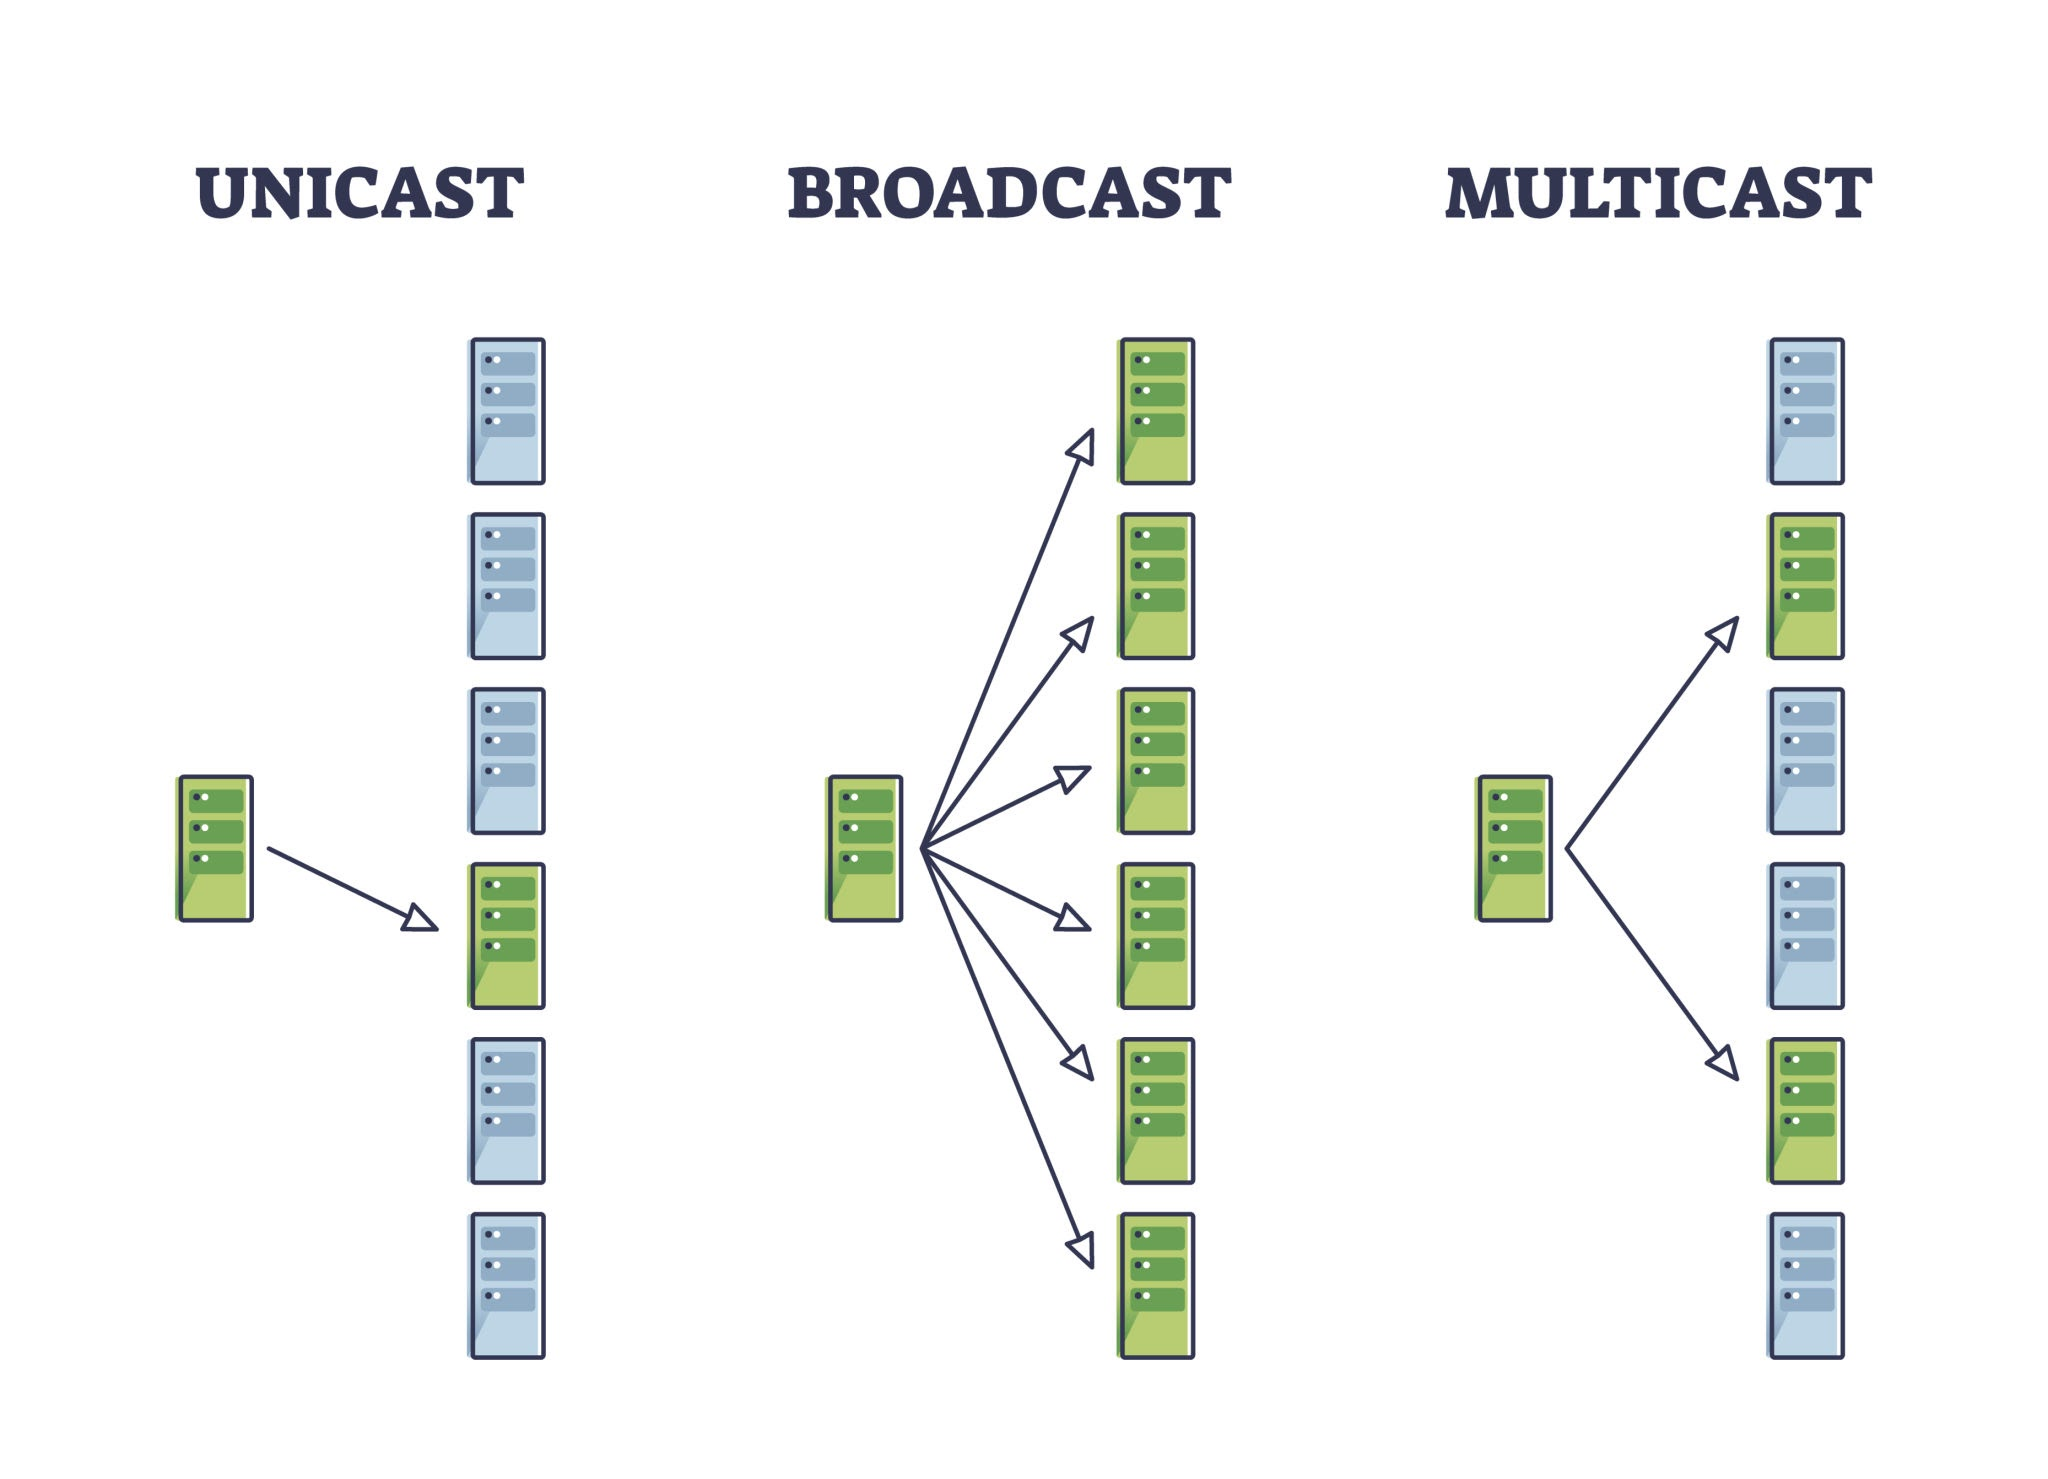

Handle Data Skew: If one key has significantly more data than others, tasks will hang waiting for that one "heavy" partition to finish.

Solution: Salt the skewed keys (add a random number to the key) to distribute the data, perform the operation, and then unsalt.

AQE: Enable Adaptive Query Execution (spark.sql.adaptive.enabled=true), which can dynamically handle skew joins in newer Spark versions (3.0+).

In [1]:
!pip install pyspark findspark

# Import necessary libraries
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession

In [3]:
# spark = SparkSession.builder \
#     .appName("PySpark Basics Tutorial") \
#     .master("local[*]") \
#     .config("spark.sql.adaptive.enabled", "true") \
#     .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
#     .getOrCreate()

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("PySparkOptimizationDemo").getOrCreate()

print("Spark version:", spark.version)


Spark version: 3.5.1


In [39]:
# --- 2️⃣ Create a synthetic dataset (5 million rows)
import pyspark.sql.functions as F

df = (
    spark.range(0, 5_000_000)
    .withColumn("category", (F.rand() * 100).cast("int"))
    .withColumn("value", (F.rand() * 1000).cast("double"))
)
df.cache()
df.count()  # triggers computation


5000000

In [40]:
df.show()

+---+--------+------------------+
| id|category|             value|
+---+--------+------------------+
|  0|      43|149.66484672366863|
|  1|      82| 144.4981555753434|
|  2|      20| 245.8600087949262|
|  3|      46|330.86457103957537|
|  4|      39| 799.2854888416703|
|  5|      44| 83.74897825921946|
|  6|      58| 343.2786097585231|
|  7|      58|187.90623629088532|
|  8|      90| 287.0228368227762|
|  9|      28| 418.9596696067769|
| 10|       5| 764.1219256929777|
| 11|      42| 91.10930082097535|
| 12|      39| 578.8743742172596|
| 13|      67| 967.1009078047647|
| 14|      41| 498.6677732365423|
| 15|      56| 759.8480428366504|
| 16|      39|  99.9690352921474|
| 17|      35| 622.6347990336986|
| 18|      86|484.56261345475883|
| 19|      96|251.22835683391776|
+---+--------+------------------+
only showing top 20 rows



In [41]:
# --- 3️⃣ Example 1: Non-optimized groupBy (no partition tuning)
import time

start = time.time()
result_slow = (
    df.groupBy("category")
    .agg(F.sum("value").alias("total_value"))
)
result_slow.count()
print("Non-optimized time:", round(time.time() - start, 2), "sec")


Non-optimized time: 1.02 sec


In [42]:
# --- 4️⃣ Optimized version: fewer shuffle partitions + column pruning
spark.conf.set("spark.sql.shuffle.partitions", "100")  # default 200, too high for small cluster

start = time.time()
result_fast = (
    df.select("category", "value")    # column pruning
      .repartition(100, "category")   # better shuffle distribution
      .groupBy("category")
      .agg(F.sum("value").alias("total_value"))
)
result_fast.count()
print("Optimized time:", round(time.time() - start, 2), "sec")


Optimized time: 5.68 sec


In [7]:
# --- 5️⃣ Example 2: Broadcast join optimization
small_df = spark.range(0, 100).withColumn("category_name", F.concat(F.lit("cat_"), F.col("id")))

# simulate large dataset join
start = time.time()
join_slow = df.join(small_df, df.category == small_df.id)
join_slow.count()
print("Join without broadcast:", round(time.time() - start, 2), "sec")

from pyspark.sql.functions import broadcast
start = time.time()
join_fast = df.join(broadcast(small_df), df.category == small_df.id)
join_fast.count()
print("Join with broadcast:", round(time.time() - start, 2), "sec")


Join without broadcast: 1.27 sec
Join with broadcast: 0.55 sec


In [8]:
# --- 6️⃣ Example 3: Avoid Python UDF — use built-in Spark SQL functions
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

@udf(DoubleType())
def slow_python_square(x):
    return float(x)**2 if x is not None else None

start = time.time()
df_udf = df.withColumn("square_val", slow_python_square(F.col("value")))
df_udf.count()
print("Python UDF time:", round(time.time() - start, 2), "sec")

# vectorized / built-in function (much faster)
start = time.time()
df_builtin = df.withColumn("square_val", F.pow(F.col("value"), 2))
df_builtin.count()
print("Built-in function time:", round(time.time() - start, 2), "sec")


Python UDF time: 0.37 sec
Built-in function time: 0.37 sec


In [9]:
# --- 7️⃣ Example 4: Inspect physical plan
df.groupBy("category").agg(F.sum("value")).explain(True)


== Parsed Logical Plan ==
'Aggregate ['category], ['category, sum('value) AS sum(value)#664]
+- Project [id#0L, category#2, cast((rand(-9072834399785878290) * cast(1000 as double)) as double) AS value#5]
   +- Project [id#0L, cast((rand(9221209948407554306) * cast(100 as double)) as int) AS category#2]
      +- Range (0, 5000000, step=1, splits=Some(2))

== Analyzed Logical Plan ==
category: int, sum(value): double
Aggregate [category#2], [category#2, sum(value#5) AS sum(value)#664]
+- Project [id#0L, category#2, cast((rand(-9072834399785878290) * cast(1000 as double)) as double) AS value#5]
   +- Project [id#0L, cast((rand(9221209948407554306) * cast(100 as double)) as int) AS category#2]
      +- Range (0, 5000000, step=1, splits=Some(2))

== Optimized Logical Plan ==
Aggregate [category#2], [category#2, sum(value#5) AS sum(value)#664]
+- Project [category#2, value#5]
   +- InMemoryRelation [id#0L, category#2, value#5], StorageLevel(disk, memory, deserialized, 1 replicas)
         +-

Narrow vs. Wide Transformations
This is the most fundamental concept in Spark optimization.

Narrow Transformation: Each partition of the parent DataFrame is used by exactly one partition of the child DataFrame. No data moves across the network.

Examples: filter, select, map, withColumn, drop.

Cost: Very Low (fast).

Wide Transformation: Data from multiple partitions is required to compute the result. This causes a Shuffle (data moving across the network between workers).

Examples: groupBy, join (standard), distinct, orderBy, repartition.

Cost: High (expensive I/O and memory).

Code Example

In [11]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# spark = SparkSession.builder.appName("OptimizationDemo").getOrCreate()

# Create dummy data
data = [(i, i * 2) for i in range(1000)]
df = spark.createDataFrame(data, ["id", "value"])

# --- Narrow Transformation Example ---
# Spark can process this purely in memory on each node independently
narrow_df = df.filter(col("value") > 500).select("id")

# --- Wide Transformation Example ---
# Spark must shuffle data to group identical keys together
wide_df = df.groupBy("id").count()

print("Narrow plan creates One-to-One dependencies.")
print("Wide plan creates Shuffle dependencies.")

Narrow plan creates One-to-One dependencies.
Wide plan creates Shuffle dependencies.


Optimization & The explain() Plan
We will look at two versions of the same query: Unoptimized vs. Optimized. We will use explain(True) (or explain(mode="extended")) to see how Spark plans to execute them.

The Scenario
We are joining a Large Table (Transactions) with a Small Table (Users) and then filtering for a specific user.

In [13]:
from pyspark.sql.functions import broadcast

# 1. Create a "Large" DataFrame (Transactions)
large_data = [(i, "User_" + str(i % 5), i * 100) for i in range(10000)]
large_df = spark.createDataFrame(large_data, ["txn_id", "user_id", "amount"])

# 2. Create a "Small" DataFrame (User Metadata)
small_data = [("User_" + str(i), "Country_" + str(i)) for i in range(5)]
small_df = spark.createDataFrame(small_data, ["user_id", "country"])

# ==========================================
# BAD QUERY (Unoptimized)
# ==========================================
# Logic: Join EVERYTHING first, then filter the result.
# Why it's bad: You shuffle all 10,000 rows, then throw away 9,900 of them.
bad_df = large_df.join(small_df, "user_id").filter(col("country") == "Country_1")

print("--- BAD QUERY PLAN ---")
# explain(True) shows Parsed, Analyzed, Optimized, and Physical plans
bad_df.explain(mode="simple")


# ==========================================
#  GOOD QUERY (Optimized)
# ==========================================
# Optimization 1: Predicate Pushdown (Filter early)
# Optimization 2: Broadcast Join (Avoid shuffle for small table)
filtered_small = small_df.filter(col("country") == "Country_1")

good_df = large_df.join(broadcast(filtered_small), "user_id")

print("\n--- GOOD QUERY PLAN ---")
good_df.explain(mode="simple")

--- BAD QUERY PLAN ---
== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Project [user_id#748, txn_id#747L, amount#749L, country#754]
   +- SortMergeJoin [user_id#748], [user_id#753], Inner
      :- Sort [user_id#748 ASC NULLS FIRST], false, 0
      :  +- Exchange hashpartitioning(user_id#748, 100), ENSURE_REQUIREMENTS, [plan_id=750]
      :     +- Filter isnotnull(user_id#748)
      :        +- Scan ExistingRDD[txn_id#747L,user_id#748,amount#749L]
      +- Sort [user_id#753 ASC NULLS FIRST], false, 0
         +- Exchange hashpartitioning(user_id#753, 100), ENSURE_REQUIREMENTS, [plan_id=751]
            +- Filter ((isnotnull(country#754) AND (country#754 = Country_1)) AND isnotnull(user_id#753))
               +- Scan ExistingRDD[user_id#753,country#754]



--- GOOD QUERY PLAN ---
== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Project [user_id#748, txn_id#747L, amount#749L, country#754]
   +- BroadcastHashJoin [user_id#748], [user_id#753], Inner, BuildRight, false


How to Read the explain() Output
When you run the code above in Colab, look at the Physical Plan (the actual steps Spark will take).

What to look for in the "Bad" Plan:
SortMergeJoin: You will likely see this. It indicates Spark sorted and shuffled both datasets to join them. This is expensive.

Filter is at the top: The Filter step happens after the Join step.

What to look for in the "Good" Plan:
BroadcastHashJoin: Instead of SortMergeJoin, you see BroadcastHashJoin. This means Spark sent the tiny filtered_small table to the large data, avoiding a massive network shuffle.

Filter is at the bottom: You will see Filter pushed down close to the Scan or LocalTableScan. This confirms Predicate Pushdown worked—Spark filtered the data before passing it up the chain.

In [17]:
# --- STEP 1: Install PySpark in Colab ---
# !pip install pyspark

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count

# Initialize Spark
#spark = SparkSession.builder.master("local[*]").appName("StudentOptimizer").getOrCreate()

# Create a dummy dataset (1 Million rows)
# This represents "Transactions"
data = [(i, i % 100) for i in range(1000000)]
df = spark.createDataFrame(data, ["txn_id", "store_id"])


In [19]:
df.show()

+------+--------+
|txn_id|store_id|
+------+--------+
|     0|       0|
|     1|       1|
|     2|       2|
|     3|       3|
|     4|       4|
|     5|       5|
|     6|       6|
|     7|       7|
|     8|       8|
|     9|       9|
|    10|      10|
|    11|      11|
|    12|      12|
|    13|      13|
|    14|      14|
|    15|      15|
|    16|      16|
|    17|      17|
|    18|      18|
|    19|      19|
+------+--------+
only showing top 20 rows



In [14]:



# --- NARROW TRANSFORMATION ---
# Concept: Spark modifies data "in-place" without moving it.
# Look at the "explain" output below. You will see "OneToOneDependency".
narrow_df = df.filter(col("store_id") == 5).select("txn_id")

print("=== NARROW PLAN (No Shuffle) ===")
narrow_df.explain()

# --- WIDE TRANSFORMATION ---
# Concept: Spark must move data so all store_id=5 rows end up on the same node.
# Look for "Exchange" in the output. "Exchange" = SHUFFLE.
wide_df = df.groupBy("store_id").agg(count("txn_id"))

print("\n=== WIDE PLAN (Shuffle!) ===")
wide_df.explain()

=== NARROW PLAN (No Shuffle) ===
== Physical Plan ==
*(1) Project [txn_id#765L]
+- *(1) Filter (isnotnull(store_id#766L) AND (store_id#766L = 5))
   +- *(1) Scan ExistingRDD[txn_id#765L,store_id#766L]



=== WIDE PLAN (Shuffle!) ===
== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[store_id#766L], functions=[count(txn_id#765L)])
   +- Exchange hashpartitioning(store_id#766L, 100), ENSURE_REQUIREMENTS, [plan_id=806]
      +- HashAggregate(keys=[store_id#766L], functions=[partial_count(txn_id#765L)])
         +- Scan ExistingRDD[txn_id#765L,store_id#766L]




In [20]:
data =[1,2,3,4,5,6]
rdd = spark.sparkContext.parallelize(data)



In [22]:
rdd2.getNumPartitions()

2

In [21]:
rdd2 = rdd.map(lambda x: x*2)

In [27]:
rdd2.mapPartitionsWithIndex(lambda idx, it: [(idx, x) for x in it]).collect()

[(0, 2), (0, 4), (0, 6), (1, 8), (1, 10), (1, 12)]

In [24]:
pairs = [("a", 1), ("b", 2), ("a", 3), ("b", 4)]
rdd3 = spark.sparkContext.parallelize(pairs)

In [25]:
rdd3.getNumPartitions()

2

In [26]:
rdd3.mapPartitionsWithIndex(lambda idx, it: [(idx, x) for x in it]).collect()

[(0, ('a', 1)), (0, ('b', 2)), (1, ('a', 3)), (1, ('b', 4))]

In [23]:

rdd4=rdd.reduceByKey(lambda x,y: x+y)
rdd4.collect()

[('b', 6), ('a', 4)]

Scan: Reading the file (Start here).

Filter: Removing useless rows (Good!).

Project: Selecting specific columns (Good!).

Exchange: Shuffling data across the network (Warning sign!).

HashAggregate: Grouping data (Often follows a shuffle)

In [15]:
from pyspark.sql.functions import broadcast

# 1. Big Table (Transactions)
df_txns = spark.range(0, 1000000).withColumnRenamed("id", "txn_id").withColumn("store_id", (col("txn_id") % 10).cast("string"))

# 2. Small Table (Store Details - only 10 rows)
stores_data = [(str(i), f"Store_Name_{i}") for i in range(10)]
df_stores = spark.createDataFrame(stores_data, ["store_id", "store_name"])

# ====================================================
#  BAD WAY: The "Shuffle-Heavy" Approach
# ====================================================
# We join 1M rows first, THEN filter for Store 1.
# This causes a "SortMergeJoin" involving all data.
bad_df = df_txns.join(df_stores, "store_id").filter(col("store_id") == "1")

print("---  BAD PLAN ---")
# Look for "SortMergeJoin" and "Exchange" (Shuffle)
bad_df.explain()

# ====================================================
# OPTIMIZED WAY: Pushdown & Broadcast
# ====================================================
# 1. Filter EARLY (Predicate Pushdown): Only keep Store 1 transactions immediately.
# 2. Broadcast Join: Send the tiny 'stores' table to the big table instead of shuffling the big table.

# Pre-filter the small table
df_stores_filtered = df_stores.filter(col("store_id") == "1")

# Use 'broadcast()' to hint Spark to send this small data to all nodes
good_df = df_txns.join(broadcast(df_stores_filtered), "store_id")

print("\n---  GOOD PLAN ---")
# Look for "BroadcastHashJoin" (Super fast, no big shuffle)
good_df.explain()

---  BAD PLAN ---
== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Project [store_id#782, txn_id#780L, store_name#786]
   +- SortMergeJoin [store_id#782], [store_id#785], Inner
      :- Sort [store_id#782 ASC NULLS FIRST], false, 0
      :  +- Exchange hashpartitioning(store_id#782, 100), ENSURE_REQUIREMENTS, [plan_id=837]
      :     +- Project [id#778L AS txn_id#780L, cast((id#778L % 10) as string) AS store_id#782]
      :        +- Filter (cast((id#778L % 10) as string) = 1)
      :           +- Range (0, 1000000, step=1, splits=2)
      +- Sort [store_id#785 ASC NULLS FIRST], false, 0
         +- Exchange hashpartitioning(store_id#785, 100), ENSURE_REQUIREMENTS, [plan_id=838]
            +- Filter ((store_id#785 = 1) AND isnotnull(store_id#785))
               +- Scan ExistingRDD[store_id#785,store_name#786]



---  GOOD PLAN ---
== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Project [store_id#782, txn_id#780L, store_name#786]
   +- BroadcastHashJoin [store_id

Concept: Imagine ordering 10 pizzas for 10 people.

Normal: Everyone eats 1 pizza. (Parallelism works!)

Skew: One person eats 9 pizzas. The other 9 people wait for him to finish. (The job hangs).

In Spark, if one Key (e.g., "NULL" or "US-User") is 90% of your data, one single CPU core will do 90% of the work while the others sit idle.

In [16]:
from pyspark.sql.functions import rand, concat, lit, floor

# Imagine "key_1" has massive data (Skewed)
# We add a "Salt" (random number 0-4) to the key
# key_1 becomes: key_1_0, key_1_1, key_1_2, key_1_3, key_1_4

# 1. Add Salt to the Big Skewed Table
df_skewed = df_txns.withColumn("salt", (rand() * 5).cast("int"))
df_skewed = df_skewed.withColumn("salted_key", concat(col("store_id"), lit("_"), col("salt")))

# 2. Explode the Small Table (Replicate it to match the salts)
# We must duplicate the small table rows so they match key_1_0, key_1_1, etc.
from pyspark.sql.functions import explode, array

# Create an array [0, 1, 2, 3, 4] and explode it to duplicate rows
df_stores_salted = df_stores.withColumn("salt_array", array([lit(i) for i in range(5)]))
df_stores_salted = df_stores_salted.select("store_id", "store_name", explode("salt_array").alias("salt"))
df_stores_salted = df_stores_salted.withColumn("salted_key", concat(col("store_id"), lit("_"), col("salt")))

# 3. Join on the new "Spread Out" key
# Now the work is split across 5 partitions instead of 1.
safe_join = df_skewed.join(df_stores_salted, "salted_key")

safe_join.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Project [salted_key#799, txn_id#780L, store_id#782, salt#795, store_id#785, store_name#786, salt#809]
   +- SortMergeJoin [salted_key#799], [salted_key#813], Inner
      :- Sort [salted_key#799 ASC NULLS FIRST], false, 0
      :  +- Exchange hashpartitioning(salted_key#799, 100), ENSURE_REQUIREMENTS, [plan_id=915]
      :     +- Project [txn_id#780L, store_id#782, salt#795, concat(store_id#782, _, cast(salt#795 as string)) AS salted_key#799]
      :        +- Filter isnotnull(concat(store_id#782, _, cast(salt#795 as string)))
      :           +- Project [id#778L AS txn_id#780L, cast((id#778L % 10) as string) AS store_id#782, cast((rand(-2754940137783663498) * 5.0) as int) AS salt#795]
      :              +- Range (0, 1000000, step=1, splits=2)
      +- Sort [salted_key#813 ASC NULLS FIRST], false, 0
         +- Exchange hashpartitioning(salted_key#813, 100), ENSURE_REQUIREMENTS, [plan_id=916]
            +- Project [store_id#

In [29]:
data = [("A",1),("A",1),("A",1),("A",5),("B",5),("C",7)]

In [34]:
df = spark.createDataFrame(data,["key","value"])
df.show()

+---+-----+
|key|value|
+---+-----+
|  A|    1|
|  A|    1|
|  A|    1|
|  A|    5|
|  B|    5|
|  C|    7|
+---+-----+



In [ ]:
skewed = df.groupBy("key").count()

In [33]:
skewed.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[key#838], functions=[count(1)])
   +- Exchange hashpartitioning(key#838, 100), ENSURE_REQUIREMENTS, [plan_id=948]
      +- HashAggregate(keys=[key#838], functions=[partial_count(1)])
         +- Project [key#838]
            +- Scan ExistingRDD[key#838,value#839L]




In [35]:
from pyspark.sql import functions as F

In [36]:
NUM_SALTS =5

In [37]:
salted =df.withColumn("salt",F.floor(F.rand()*NUM_SALTS))

In [38]:
partail = salted .groupBy("key","salt").agg(F.sum("value").alias("part_sum"))